In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from thop import profile  

# Load and preprocess the connectivity matrix
# compare with MLP and Logistic Regression
csv_path = './data/ad_connectivity_matrix.csv'
W_df = pd.read_csv(csv_path, index_col=0, header=0)
W = W_df.values.astype(np.float32)
W_min = W.min()
W_max = W.max()
W = (W - W_min) / (W_max - W_min + 1e-8)

class Perceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        out = self.fc(x)
        return out
    
# C remain untrained
class DrosophilaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, W_matrix, pos_ratio=0.7, is_pruned=False):
        super(DrosophilaRNN, self).__init__()
        self.input_to_hidden = nn.Linear(input_size, hidden_size, bias=True)
        self.hidden_to_output = nn.Linear(hidden_size, output_size, bias=True)

        self.hidden_size = hidden_size
        self.is_pruned = is_pruned  # Flag for pruning

        # --- 1) Make C trainable, initialized as all ones ---
        self.C = nn.Parameter(torch.ones(hidden_size, hidden_size))  # Initialize C as all ones

        # --- 2) W: Learnable weight matrix ---
        self.W = nn.Parameter(torch.tensor(W_matrix, dtype=torch.float32) * 0.001)

        # --- 3) s: Sign vector, freeze 70% +1 and 30% -1 ---
        num_pos = int(pos_ratio * hidden_size)
        num_neg = hidden_size - num_pos
        sign_array = np.array([1]*num_pos + [-1]*num_neg, dtype=np.float32)
        np.random.shuffle(sign_array)
        s_tensor = torch.tensor(sign_array)
        self.register_buffer("s", s_tensor)  # not trainable

        # Freeze C after each pruning to maintain sparsity
        self.C.requires_grad = False  # Freeze C so it doesn't update with gradients

    def forward(self, x):
        batch_size, time_steps, _ = x.shape

        # hidden state
        r_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Build W_fly = (C * W) * s (row-wise multiply)
        W_fly = self.C * self.W
        W_fly = W_fly * self.s.unsqueeze(1)  # shape [hidden_size, hidden_size]

        for t in range(time_steps):
            E_t = x[:, t, :]  # (batch, input_size)
            E_t_hidden = self.input_to_hidden(E_t)
            r_prev = r_t
            r_t = r_t @ W_fly
            r_t = r_t + E_t_hidden
            r_t = r_t + r_prev  # residual connection
            r_t = torch.relu(r_t)

        out = self.hidden_to_output(r_t)
        return out
    
def revive_C_based_on_gradient(model, decay_factor=0.01):
    with torch.no_grad():
        gradient_magnitude = model.W.grad.abs()  # Get absolute gradients of W
        gradient_magnitude_rescaled = torch.unsqueeze(gradient_magnitude, 0) * torch.unsqueeze(gradient_magnitude, 1)
        revived_connections = (model.C.data == 0) * (gradient_magnitude_rescaled > decay_factor)
        model.C.data = model.C.data + revived_connections.float()
        
def prune_C_by_magnitude(model, target_nonzero_count):
    with torch.no_grad():
        c_abs = model.C.data.abs()
        threshold = torch.topk(c_abs.view(-1), target_nonzero_count).values[-1]
        mask = (c_abs >= threshold).float()
        model.C.data = mask

# Define the training function with batch-level pruning and revival strategy
def train_model(model, model_type, optimizer, num_epochs, record_interval, device, train_loader, dummy_input_shape, target_nonzero_count, tag="drosophila"):
    criterion = nn.CrossEntropyLoss()
    epoch_loss_list = []
    epoch_acc_list = []

    # To accumulate FLOPs (recorded at each record_interval)
    flops_list = []
    loss_list = []
    acc_list = []

    cumulative_flops = 0
    batch_counter = 0

    dummy_input = torch.randn(dummy_input_shape).to(device)
    macs, _ = profile(model, inputs=(dummy_input,), verbose=False)
    flops_per_sample = macs * 2  # Multiply by 2 to get the FLOPs per forward pass
    print(f"[{model_type}] FLOPs per sample: {flops_per_sample}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        with tqdm(train_loader, unit="batch", desc=f"Training [{tag}] Epoch {epoch+1}/{num_epochs}") as tepoch:
            for images, labels in tepoch:
                if model_type == 'rnn':
                    inputs = images.squeeze(1).to(device)  # (batch, 28, 28)
                else:
                    inputs = images.view(images.size(0), -1).to(device)  # (batch, 784)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()

                batch_size_curr = inputs.size(0)
                running_loss += loss.item() * batch_size_curr
                _, predicted = torch.max(outputs, dim=1)
                running_correct += (predicted == labels).sum().item()
                running_total += batch_size_curr

                # Accumulate FLOPs
                cumulative_flops += flops_per_sample * batch_size_curr
                batch_counter += 1

                if batch_counter % record_interval == 0:
                    current_loss = running_loss / running_total
                    current_acc = running_correct / running_total
                    flops_list.append(cumulative_flops)
                    loss_list.append(current_loss)
                    acc_list.append(current_acc)

                tepoch.set_postfix(loss=loss.item(), accuracy=running_correct / running_total)

            # Prune C after every batch, maintaining a fixed number of non-zero entries
            prune_C_by_magnitude(model, target_nonzero_count)

            # Revive some pruned connections based on gradient information
            revive_C_based_on_gradient(model)

        # End of epoch stats
        epoch_loss = running_loss / running_total
        epoch_acc = running_correct / running_total
        epoch_loss_list.append(epoch_loss)
        epoch_acc_list.append(epoch_acc)

        print(f"{model_type} Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc*100:.2f}%")

    return epoch_loss_list, epoch_acc_list, flops_list, loss_list, acc_list

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)
tag='drosophila_pruning'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
batch_size = 64
nepochs = 5
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# RNN with pruning enabled
hidden_size = W.shape[0]
target_nonzero_count = torch.sum(torch.tensor(W != 0))  # Initial non-zero connections in W
model_rnn_CWS_pruned = DrosophilaRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_matrix=W, is_pruned=True).to(device)
optimizer_rnn_CWS_pruned = optim.Adam(model_rnn_CWS_pruned.parameters(), lr=1e-5)
results_rnn_CWS_pruned = train_model(model_rnn_CWS_pruned, model_type='rnn', optimizer=optimizer_rnn_CWS_pruned, num_epochs=nepochs,
                                 record_interval=10, device=device, train_loader=train_loader, dummy_input_shape=(1,28,28), target_nonzero_count=target_nonzero_count, tag=tag)

model_rnn_CWS = DrosophilaRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_matrix=W, is_pruned=False).to(device)
optimizer_rnn_CWS = optim.Adam(model_rnn_CWS.parameters(), lr=1e-5)
results_rnn_CWS = train_model(model_rnn_CWS, model_type='rnn', optimizer=optimizer_rnn_CWS, num_epochs=nepochs,
                                 record_interval=10, device=device, train_loader=train_loader, dummy_input_shape=(1,28,28), target_nonzero_count=target_nonzero_count, tag=tag)


In [ ]:
# Set up training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)
tag='drosophila_pruning'


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
batch_size = 64
nepochs = 5
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DrosophilaRNN with pruning enabled
hidden_size = W.shape[0]
model_rnn_CWS_pruned = DrosophilaRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_matrix=W, is_pruned=True).to(device)
optimizer_rnn_CWS_pruned = optim.Adam(model_rnn_CWS_pruned.parameters(), lr=1e-5)
results_rnn_CWS_pruned = train_model(model_rnn_CWS_pruned, model_type='rnn', optimizer=optimizer_rnn_CWS_pruned, num_epochs=nepochs,
                                 record_interval=10, device=device, train_loader=train_loader, dummy_input_shape=(1,28,28), tag=tag)

model_rnn_CWS = DrosophilaRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_matrix=W, is_pruned=False).to(device)
optimizer_rnn_CWS = optim.Adam(model_rnn_CWS.parameters(), lr=1e-5)
results_rnn_CWS = train_model(model_rnn_CWS, model_type='rnn', optimizer=optimizer_rnn_CWS, num_epochs=nepochs,
                                 record_interval=10, device=device, train_loader=train_loader, dummy_input_shape=(1,28,28), tag=tag)



Using: cpu
[rnn] FLOPs per sample: 4687776.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [06:03<00:00,  2.58batch/s, accuracy=0.665, loss=0.446]


rnn Epoch 1/5: Loss = 1.1252, Accuracy = 66.54%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [06:09<00:00,  2.54batch/s, accuracy=0.924, loss=0.175]  


rnn Epoch 2/5: Loss = 304.8425, Accuracy = 92.38%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [06:08<00:00,  2.55batch/s, accuracy=0.978, loss=0.00382]


rnn Epoch 3/5: Loss = 0.0729, Accuracy = 97.76%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [06:06<00:00,  2.56batch/s, accuracy=0.986, loss=0.00491] 


rnn Epoch 4/5: Loss = 0.0434, Accuracy = 98.64%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [06:06<00:00,  2.56batch/s, accuracy=0.99, loss=0.000405] 


rnn Epoch 5/5: Loss = 0.0328, Accuracy = 99.00%
[rnn] FLOPs per sample: 4687776.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [06:04<00:00,  2.57batch/s, accuracy=0.663, loss=0.693]


rnn Epoch 1/5: Loss = 1.1081, Accuracy = 66.28%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [06:05<00:00,  2.57batch/s, accuracy=0.852, loss=0.271]


rnn Epoch 2/5: Loss = 0.5329, Accuracy = 85.16%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [06:05<00:00,  2.57batch/s, accuracy=0.889, loss=0.312]


rnn Epoch 3/5: Loss = 0.3975, Accuracy = 88.91%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [06:05<00:00,  2.57batch/s, accuracy=0.909, loss=0.175]


rnn Epoch 4/5: Loss = 0.3248, Accuracy = 90.94%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [06:05<00:00,  2.57batch/s, accuracy=0.922, loss=0.364] 


rnn Epoch 5/5: Loss = 0.2784, Accuracy = 92.25%
[fc] FLOPs per sample: 158800.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [00:03<00:00, 243.88batch/s, accuracy=0.92, loss=0.071]  


fc Epoch 1/5: Loss = 0.2723, Accuracy = 92.03%


AttributeError: 'Perceptron' object has no attribute 'is_pruned'

In [23]:
# Perceptron model for comparison
model_perc = Perceptron(input_dim=28*28, hidden_dim=100, output_dim=10).to(device)
optimizer_perc = optim.Adam(model_perc.parameters(), lr=1e-3)
results_perc = train_model(model_perc, model_type='fc', optimizer=optimizer_perc, num_epochs=nepochs,
                           record_interval=100, device=device, train_loader=train_loader, dummy_input_shape=(1,28*28), tag=tag)

# Logistic Regression model for comparison
model_logreg = LogisticRegression(input_dim=28*28, output_dim=10).to(device)
optimizer_logreg = optim.Adam(model_logreg.parameters(), lr=1e-3)
results_logreg = train_model(model_logreg, model_type='fc', optimizer=optimizer_logreg, num_epochs=nepochs,
                             record_interval=100, device=device, train_loader=train_loader, dummy_input_shape=(1,28*28), tag=tag)

[fc] FLOPs per sample: 158800.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [00:03<00:00, 243.06batch/s, accuracy=0.92, loss=0.111]  


fc Epoch 1/5: Loss = 0.2664, Accuracy = 92.02%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [00:03<00:00, 249.54batch/s, accuracy=0.965, loss=0.119] 


fc Epoch 2/5: Loss = 0.1189, Accuracy = 96.45%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [00:03<00:00, 248.01batch/s, accuracy=0.975, loss=0.0652] 


fc Epoch 3/5: Loss = 0.0845, Accuracy = 97.46%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [00:03<00:00, 241.45batch/s, accuracy=0.98, loss=0.071]   


fc Epoch 4/5: Loss = 0.0663, Accuracy = 97.98%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [00:03<00:00, 254.35batch/s, accuracy=0.984, loss=0.0076] 


fc Epoch 5/5: Loss = 0.0524, Accuracy = 98.38%
[fc] FLOPs per sample: 15680.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [00:03<00:00, 274.70batch/s, accuracy=0.891, loss=0.132] 


fc Epoch 1/5: Loss = 0.3794, Accuracy = 89.13%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [00:03<00:00, 271.50batch/s, accuracy=0.917, loss=0.197] 


fc Epoch 2/5: Loss = 0.2914, Accuracy = 91.67%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [00:03<00:00, 267.96batch/s, accuracy=0.921, loss=0.251] 


fc Epoch 3/5: Loss = 0.2814, Accuracy = 92.09%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [00:03<00:00, 250.92batch/s, accuracy=0.923, loss=0.12]  


fc Epoch 4/5: Loss = 0.2758, Accuracy = 92.35%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [00:03<00:00, 270.18batch/s, accuracy=0.924, loss=0.889] 

fc Epoch 5/5: Loss = 0.2707, Accuracy = 92.44%


In [ ]:
results = {
    "FlyRNN_CWS_Pruned": {
        "epoch_loss": results_rnn_CWS_pruned[0],
        "epoch_acc": results_rnn_CWS_pruned[1],
        "flops": results_rnn_CWS_pruned[2],
        "loss": results_rnn_CWS_pruned[3],
        "acc": results_rnn_CWS_pruned[4],
    },
    "FlyRNN_CWS": {
        "epoch_loss": results_rnn_CWS[0],
        "epoch_acc": results_rnn_CWS[1],
        "flops": results_rnn_CWS[2],
        "loss": results_rnn_CWS[3],
        "acc": results_rnn_CWS[4],
    },
    "Perceptron": {
        "epoch_loss": results_perc[0],
        "epoch_acc": results_perc[1],
        "flops": results_perc[2],
        "loss": results_perc[3],
        "acc": results_perc[4]
    },
    "LogisticRegression": {
        "epoch_loss": results_logreg[0],
        "epoch_acc": results_logreg[1],
        "flops": results_logreg[2],
        "loss": results_logreg[3],
        "acc": results_logreg[4]
    },
}

with open(f"{tag}.pkl", "wb") as f:
    pickle.dump(results, f)
print(f"saved to {tag}.pkl")

with open(f"{tag}.pkl", "rb") as f:
    loaded_results = pickle.load(f)

def normalize_curve(curves):
    all_vals = []
    for val_list in curves.values():
        all_vals.extend(val_list)
    global_min = min(all_vals)
    global_max = max(all_vals)
    norm_curves = {}
    for name, vals in curves.items():
        norm_curves[name] = [(v - global_min) / (global_max - global_min) for v in vals]
    return norm_curves

epoch_loss_curves = {
    model_name: data["epoch_loss"] for model_name, data in loaded_results.items()
}
flops_loss_curves = {
    model_name: data["loss"] for model_name, data in loaded_results.items()
}
norm_epoch_loss = normalize_curve(epoch_loss_curves)
norm_flops_loss = normalize_curve(flops_loss_curves)

训练结果已保存到 drosophila_pruning.pkl


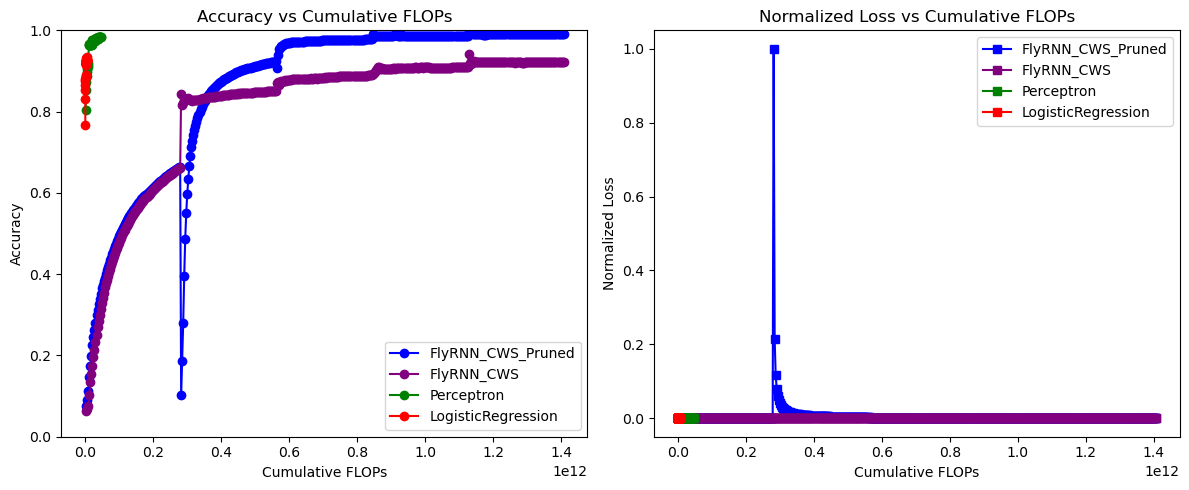

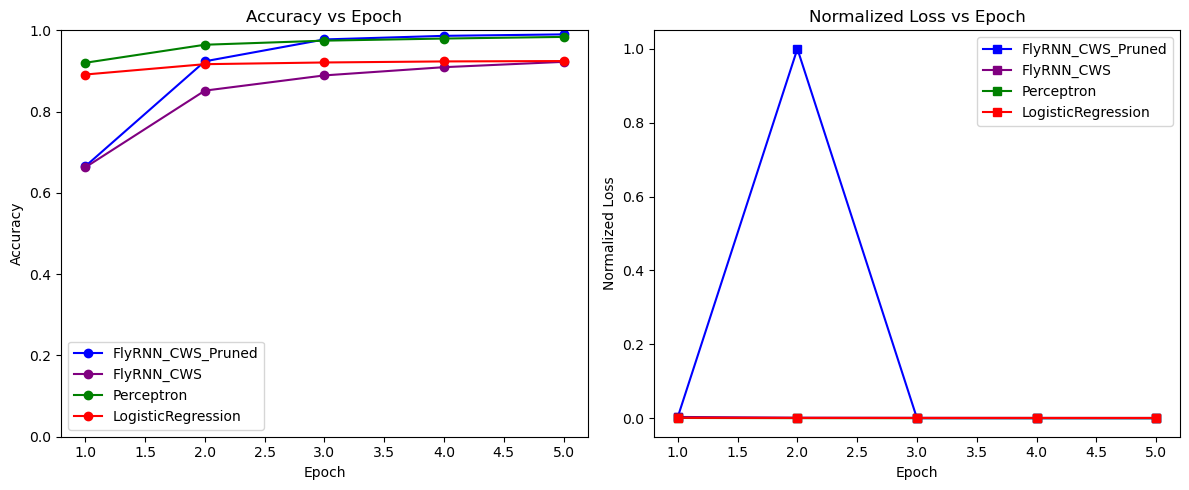

In [ ]:
colors = {"FlyRNN_CWS_Pruned": "blue","FlyRNN_CWS": "purple", "Perceptron": "green", "LogisticRegression": "red"}

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for model_name, data in loaded_results.items():
    plt.plot(data["flops"], data["acc"], marker='o', color=colors[model_name], label=model_name)
plt.title("Accuracy vs Cumulative FLOPs")
plt.xlabel("Cumulative FLOPs")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.legend()

plt.subplot(1,2,2)
for model_name, norm_loss in norm_flops_loss.items():
    plt.plot(loaded_results[model_name]["flops"], norm_loss, marker='s', color=colors[model_name], label=model_name)
plt.title("Normalized Loss vs Cumulative FLOPs")
plt.xlabel("Cumulative FLOPs")
plt.ylabel("Normalized Loss")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for model_name, data in loaded_results.items():
    epochs = range(1, len(data["epoch_acc"]) + 1)
    plt.plot(epochs, data["epoch_acc"], marker='o', color=colors[model_name], label=model_name)
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.legend()

plt.subplot(1,2,2)
for model_name, norm_loss in norm_epoch_loss.items():
    epochs = range(1, len(norm_loss) + 1)
    plt.plot(epochs, norm_loss, marker='s', color=colors[model_name], label=model_name)
plt.title("Normalized Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def plot_results(pickle_files, labels):
    plt.figure(figsize=(8,6))
    for pkl_file, lab in zip(pickle_files, labels):
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)
        train_accuracies = data['train_accuracies']
        epochs = range(1, len(train_accuracies)+1)
        plt.plot(epochs, train_accuracies, label=lab)
    plt.title("Training Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

files = ["drosophila_CWS_no_puring.pkl","drosophila_CWS_puring.pkl"]
labels = ["No puring","Puring"]
plot_results(files, labels)